<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_SetVAE_v2_(MSE%2BCD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Feature                         | PointNet Encoder                                            | Induced Set Attention Block (ISAB)                             |
|---------------------------------|-------------------------------------------------------------|-----------------------------------------------------------------|
| **Core Components**             | Pointwise (1D) Convolutions + Max Pooling                   | Multi-head Attention with Inducing Points                       |
| **Permutation Invariance**      | Achieved by Global Max Pooling                              | Achieved by Attention mechanism (order-independent)             |
| **Modeling Point Interactions** | Does **NOT** explicitly model point interactions (points processed independently) | **Explicitly models interactions** between points via Attention |
| **Hierarchical Information**    | Limited (Single-layer aggregation)                          | Capable of capturing **hierarchical structures** via two-step Attention |
| **Information Loss**            | High (Due to simple aggregation by max-pooling)             | Lower (Attention preserves detailed relationships)              |
| **Scalability & Efficiency**    | Very efficient and scalable                                 | Efficient with inducing points, though slightly more complex computationally |
| **Representation Richness**     | Limited (individual points aggregated simply)               | High (multiple attention heads capture diverse relations)       |
| **Impact on VAE Reconstruction Error** | Potentially higher (due to limited interaction modeling) | **Potentially lower** (due to capturing detailed structures)    |


https://www.hello-statisticians.com/ml/deeplearning/set_transformer1.html

In [ ]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 21.0 MB/s eta 0:00:00


In [ ]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "SetVAE.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/SetVAE.py",
    "ISAB.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ISAB.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
SetVAE.py downloaded successfully.
ISAB.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.


In [ ]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import SetVAE
import ISAB
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from SetVAE import SetVAE
from ISAB import ISAB
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data_for_ISAB

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 10.90 GB


In [ ]:
import torch
import torch.optim as optim
import numpy as np



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data_for_ISAB(file_names, num_points=num_points, device=device)
print(len(data_loader))
# VAEモデル構築
vae = SetVAE(num_points=5000, n_z=3, dim_input=3, dim_hidden=128, num_heads=4, num_inds=32).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1.0e-4)

9


In [ ]:
epochs=5000
interval=100

cd_error_record = []
rec_error_record = []
reg_error_record = []
total_error_record = []
z_list = []

for i in range(epochs):
    vae.train()
    loss_rec = 0
    loss_cd = 0
    loss_reg = 0
    loss_total = 0

    for k, (x,) in enumerate(data_loader):
            # xをdeviceに移動
            x = x.to(device)


            # VAEの出力と損失を計算
            y, z, mu, logvar = vae(x)  #
            lrec, lcd, lreg = vae.loss2(y, x, mu, logvar)
            loss = 0.5 * lrec + 10 * lcd + 0.4 * lreg

            # 損失の合計を計算

            loss_rec += 0.5 * lrec.item()
            loss_cd += 10 * lcd.item()
            loss_reg += 0.4 * lreg.item()
            loss_total += loss.item()

            # 最適化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 最終エポックでzを収集
            if i == epochs - 1:
                z_list.append(z.cpu().detach().numpy())

    # 各エポックでの平均損失計算（バッチ数で割る）
    loss_rec /= (k + 1)
    loss_cd /= (k + 1)
    loss_reg /= (k + 1)
    loss_total /= (k + 1)

    rec_error_record.append(loss_rec)
    cd_error_record.append(loss_cd)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    if i % interval == 0:
        print(f"Epoch: {i} Loss_Rec: {loss_rec:.4f} Loss_CD: {loss_cd:.4f} Loss_Reg: {loss_reg:.4f} Loss_Total: {loss_total:.4f}")

# 最終エポック後に z_list を保存
if len(z_list) > 0:
    z_array = np.array(z_list)
    np.save("z_list_final.npy", z_array)
    print(f"z_list saved with shape: {z_array.shape}")
else:
    print("Warning: z_list is empty. Nothing was saved.")

Epoch: 0 Loss_Rec: 13502.4010 Loss_CD: 14.8371 Loss_Reg: 0.8994 Loss_Total: 13518.1377
Epoch: 100 Loss_Rec: 507.7954 Loss_CD: 1.5467 Loss_Reg: 4.1107 Loss_Total: 513.4528
Epoch: 200 Loss_Rec: 347.8372 Loss_CD: 1.2018 Loss_Reg: 4.3725 Loss_Total: 353.4114
Epoch: 300 Loss_Rec: 302.4966 Loss_CD: 1.2446 Loss_Reg: 4.2470 Loss_Total: 307.9882
Epoch: 400 Loss_Rec: 198.6737 Loss_CD: 1.0890 Loss_Reg: 4.2766 Loss_Total: 204.0392
Epoch: 500 Loss_Rec: 95.2407 Loss_CD: 0.8951 Loss_Reg: 4.5093 Loss_Total: 100.6451
Epoch: 600 Loss_Rec: 67.4080 Loss_CD: 0.9185 Loss_Reg: 4.5768 Loss_Total: 72.9033
Epoch: 700 Loss_Rec: 42.5020 Loss_CD: 0.7724 Loss_Reg: 4.6675 Loss_Total: 47.9419
Epoch: 800 Loss_Rec: 20.9282 Loss_CD: 0.5943 Loss_Reg: 4.8162 Loss_Total: 26.3386
Epoch: 900 Loss_Rec: 21.9873 Loss_CD: 0.6168 Loss_Reg: 4.7227 Loss_Total: 27.3267
Epoch: 1000 Loss_Rec: 88.8598 Loss_CD: 1.0380 Loss_Reg: 4.5051 Loss_Total: 94.4030
Epoch: 1100 Loss_Rec: 89.0391 Loss_CD: 0.9890 Loss_Reg: 4.3247 Loss_Total: 94.3529


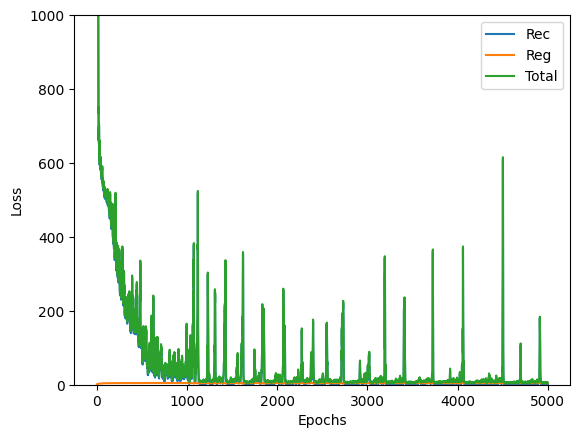

Model weights have been saved!


In [ ]:
# 損失の可視化
visualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
torch.save(vae.state_dict(), '/content/drive/MyDrive/chair/SetVAE_Np5000_MSECD_0314.pth')
print("Model weights have been saved!")

In [ ]:
print(z_list) # z mu logvar

[array([[ 1.0056281 ,  0.28429437, -0.05671043]], dtype=float32), array([[ 0.41325885,  0.42309672, -0.8634327 ]], dtype=float32), array([[ 0.6736456 ,  0.30285433, -0.48817894]], dtype=float32), array([[ 0.87395996, -0.33148244,  0.23356263]], dtype=float32), array([[ 0.68958116, -0.25398496, -0.35484323]], dtype=float32), array([[ 0.65717876, -0.9718597 , -0.10746785]], dtype=float32), array([[ 0.61357677,  0.8380946 , -0.1453608 ]], dtype=float32), array([[ 0.5184375 , -0.19998114, -1.0182552 ]], dtype=float32), array([[0.8449815 , 0.2709357 , 0.58999777]], dtype=float32)]


# 再構成形状の可視化

torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])


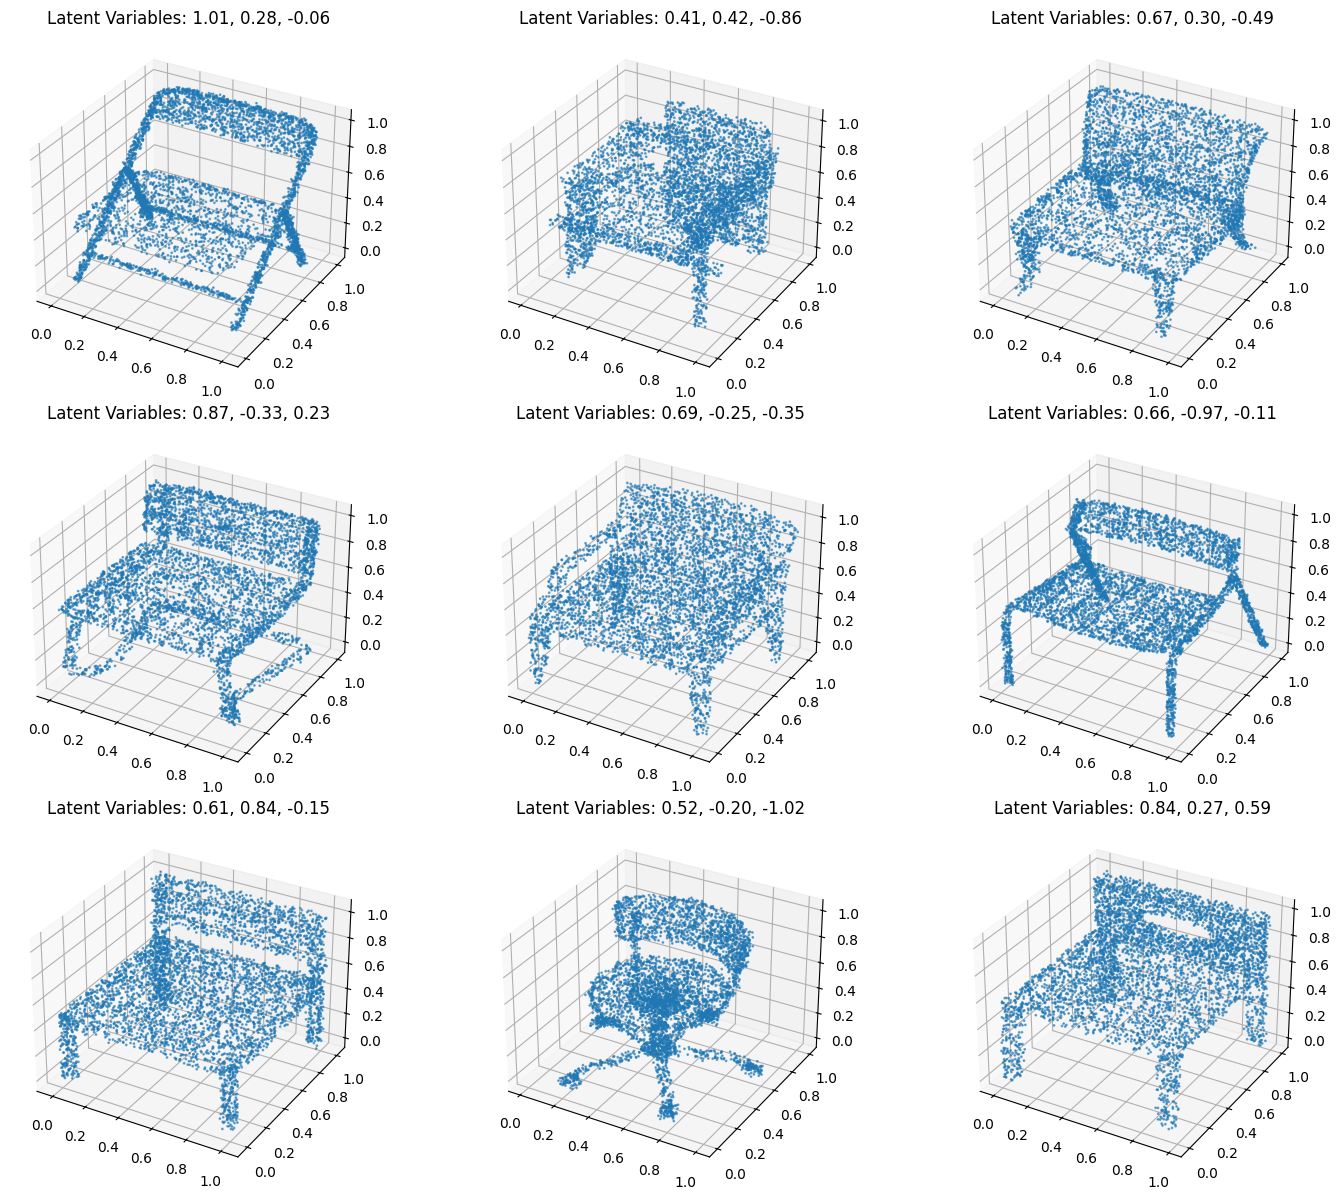

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    recon_batch = vae.decode(z)  # z をバッチの形状に変換
    print(recon_batch.shape)

    # CPU上で detach して numpy に変換
    # デコード結果 recon_batch: (1, num_points, 3)
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得
    reconst_x = reconst_np[:, 0]
    reconst_y = reconst_np[:, 1]
    reconst_z = reconst_np[:, 2]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()

# 再構成誤差チェック using CD

Chamfer Distances: [0.01655140519142151, 0.017170187085866928, 0.022635754197835922, 0.015637865290045738, 0.0223256703466177, 0.01310642622411251, 0.02053960971534252, 0.01723286882042885, 0.03489190340042114]
Average Chamfer Distance: 0.020010187808010314


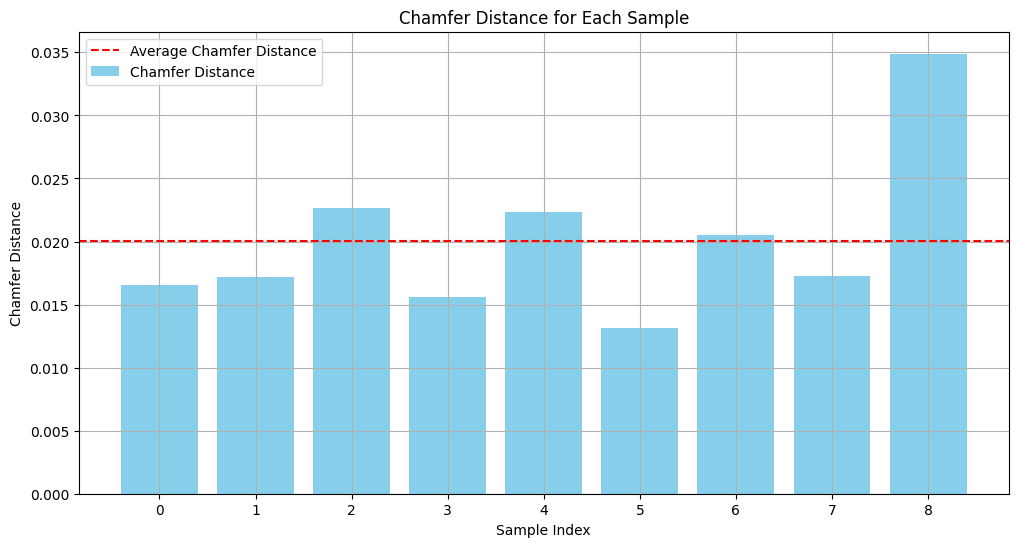

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
reconstructed_point_cloud=[]
# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = vae.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()

# 再構成誤差チェック using EMD

EMD Distances: [0.011154709267293554, 0.009279076375374567, 0.013973435833394065, 0.008616117869795095, 0.01320423383221283, 0.007907824515039324, 0.01177721903903796, 0.010298501024299198, 0.02378445911154811]
Average EMD Distance: 0.012221730763110525


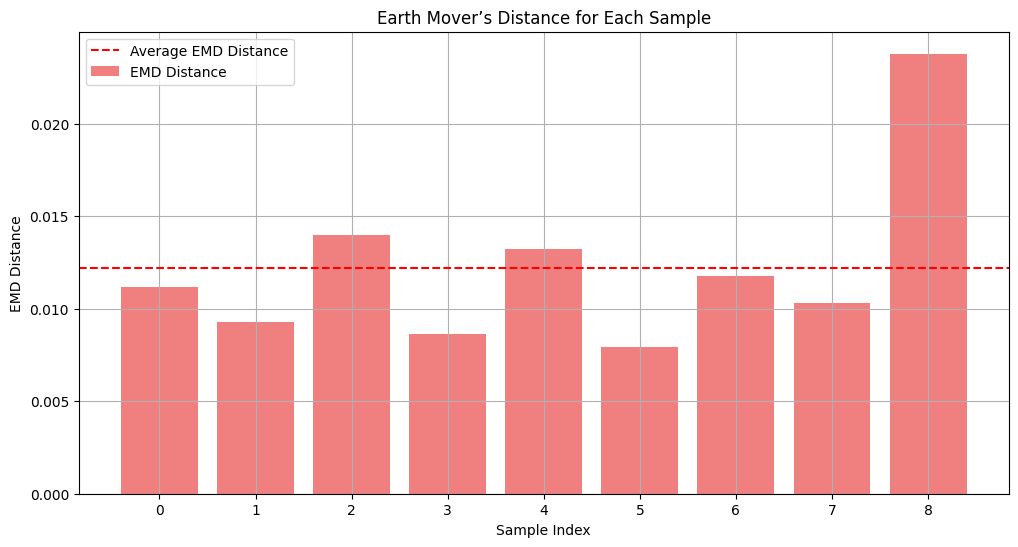

In [ ]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
reconstructed_point_cloud=[]
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = vae.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)
    reconstructed_point_cloud = reconstructed_point_cloud.reshape(num_points, 3).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()